# Titanic

## Can we leverage deep learning on irregular domains to save lifes?

---

*Teo Stocco, Pierre-Alexandre Lee, Yves Lamonato, Charles Thiebaut*, [EPFL](https://epfl.ch).

[Network Tour of Data Science](https://github.com/mdeff/ntds_2017) final project. This notebook contains a detailed overview through the whole project with all essential parts. As this work required several attempts and exploration, only relevant parts are kept here. You can however access their associated notebooks (unguided) with all processes when mentionned. This project was **not shared** with any other class.


[Binder access](https://mybinder.org/v2/gh/zifeo/Titanic/) | [nbviewer access](https://nbviewer.jupyter.org/github/zifeo/Titanic/blob/master/project.ipynb)

TODO:

- spell check plugin
- isolate code blocks in functions in separate Python module
- abstract
- notebook toc plugin
- README with getting started

## 1 Introduction

Icebergs and ships do not get well along each other. To avoid dramatic events such as the one that happened a century ago, we aim at helping a noble quest: differentiating icebergs and ships based on radar data to see whether any
iceberg is drifting away and might cross the road of a ship.

|© Statoil/C-CORE - Icebergs and ships examples|
|-|
|![](./img/statoil-ccore.png)|

This remote sensing measurements can be performed either by planes or by satellites. The latter can provide radar information up to 14 time a day as in the case of [Sentinel-1](https://fr.wikipedia.org/wiki/Sentinel-1). The C-Band radar manage to capture data in numerous conditions (e.g. darkness, rain, cloud, fog, etc.) and measures the energy reflected back called backscatter (Torres et al, 2012). Those data can latter be analyzed and used to clear out potential collision between icebergs and ships. 

Building on the top of recent advances in the field of signal processing on graphs (Schuman et al., 2013) and deep learning on irregular domains (Bronstein et al., 2017), we investigate the performance of standard machine learning methods and the relevance of graph based convolutional neural networks to perform binary classification in this specific case. The new method provide a convenient way of getting rotational invariance over the data and set up a flexible framework for structured pooling (Defferrard et al., 2017). Pooling operations require adequate aggregation by coarsening the graph between layers. We experiment how this framework can be exploited through various processes: Graclus multilevel algorithm, ... TODO

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sys
import os

In [3]:
# add gcnn module
sys.path.append('..')

# bigger figure
plt.rcParams['figure.figsize'] = 18, 5

In [4]:
# setting seed for reproducability
np.random.seed(0)
torch.manual_seed(0);

In [5]:
# scope to specfic gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## 2 Data source

The dataset is provided by Statoil, an oil and gas compagny, and C-CORE, a monitoring company using compute vision, to keep operations safe and efficient. It was released on Kaggle for prediction competition in late 2017. The full dataset contains 10'028 iceberg or ship cases with only 1'604 labelled. Some of the images were computer generated to avoid hand labelling in the competition. As we will only focus on labelled one, this should not matter. 

### Description

- HH: transmit and receive horizontally
- HV: transmit horizontally and receive vertically

Quantitative vs Qualitative


| Feature | Description | Type | Has N/A | Comment |
| - | - | - | - | - |
| id | | | | |
| band_1 | | | | unit?
| band_2 | | | | unit? |
| inc_angle | | | | what impact ? unit? cause? |
| is_iceberg | | | | |

In [6]:
from gcnn.datasets import load_icebergs

measures = load_icebergs('train')
measures.head(4)

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0


In [7]:
measures.shape

(1604, 4)

### Exploration

> More details on associated notebook [xx]()

some more cases

Let's have a look at an example of iceberg.

In [8]:
example_iceberg = measures.iloc[5]
example_iceberg

band_1        [-20.769371, -20.769434, -25.906025, -25.90602...
band_2        [-29.288746, -29.712593, -28.884804, -28.88480...
inc_angle                                               36.9034
is_iceberg                                                    1
Name: b51d18b5, dtype: object

In [9]:
from gcnn import viz

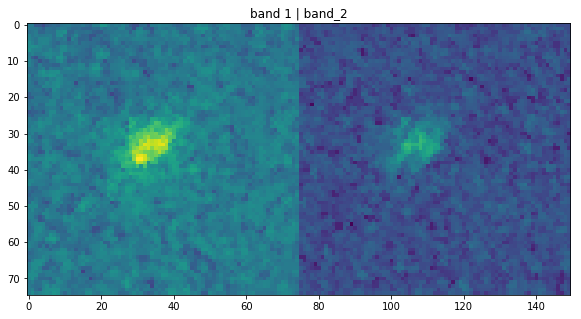

In [10]:
viz.plot_bands(example_iceberg)

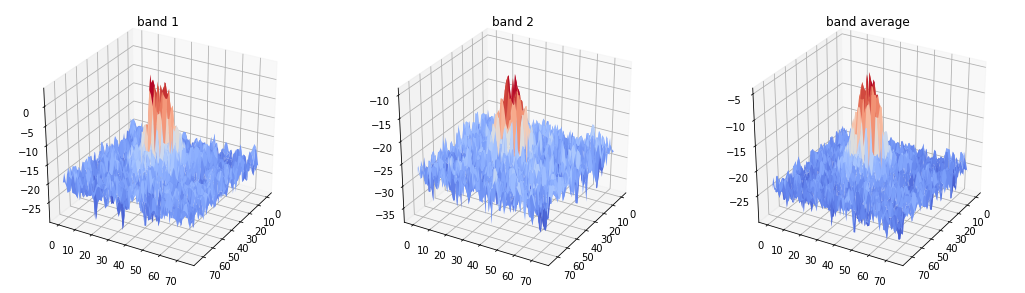

In [11]:
viz.plot_bands_3d(example_iceberg)

- varies a lot in size
- "intensity" difference
- lots of backscatter noise

---

Let's now look at an example of a ship.

In [12]:
example_ship = measures.iloc[0]
example_ship

band_1        [-27.878360999999998, -27.15416, -28.668615, -...
band_2        [-27.154118, -29.537888, -31.0306, -32.190483,...
inc_angle                                               43.9239
is_iceberg                                                    0
Name: dfd5f913, dtype: object

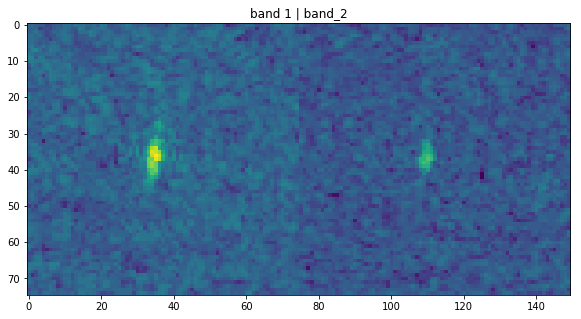

In [13]:
viz.plot_bands(example_ship)

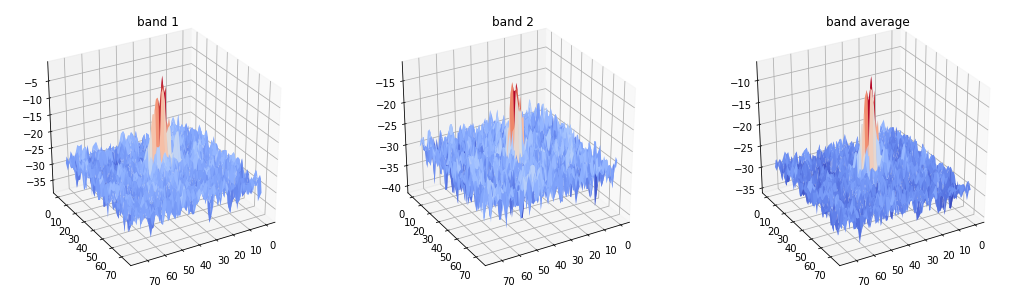

In [14]:
viz.plot_bands_3d(example_ship, angle=60)

- some elongated shape
- other angle but not visible from eye
- still lots of noise

---

What about the distribution of the data and correlation ?

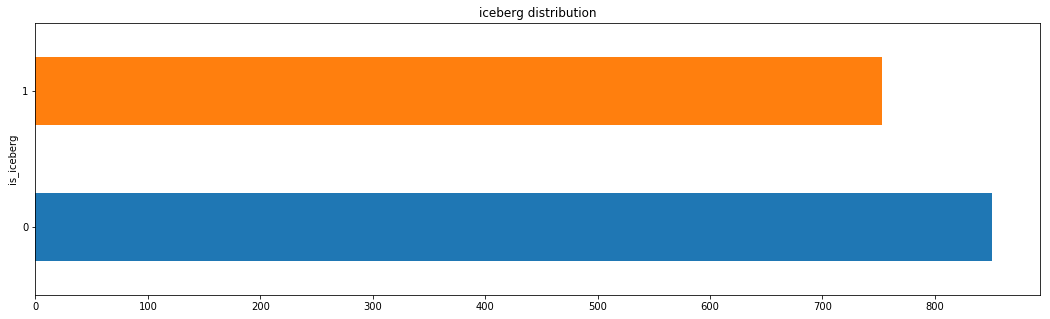

In [15]:
plt.title('iceberg distribution')
measures.groupby(measures.is_iceberg).is_iceberg.count().plot.barh();

distribution of bands and angle? covariance

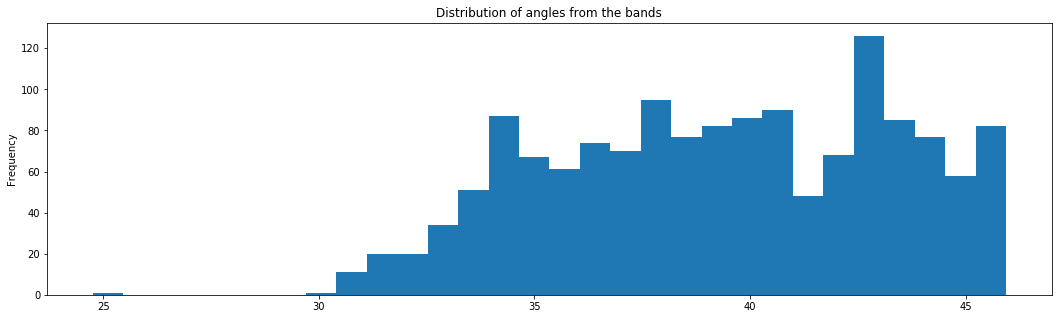

In [54]:
plt.title("Distribution of angles from the bands")
measures.inc_angle.plot.hist(bins=30);

In [55]:
measures.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


133 of the measures have an absent angle, so we just ignore them for the correlation measure.

In [65]:
#
measures_clean = measures[measures.inc_angle.notnull()]

We can see below that there isn't an high apparent correlation between the angle of the measure and the label.

In [67]:
np.corrcoef(measures_clean.inc_angle, measures_clean.is_iceberg)

array([[ 1.        , -0.00503896],
       [-0.00503896,  1.        ]])

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
pca = PCA(n_components=50).fit_transform(np.c_[np.stack(measures.band_1), np.stack(measures.band_2)])
# pca speed up T-SNE and suppress some noise
tsne = TSNE(n_components=2).fit_transform(pca)

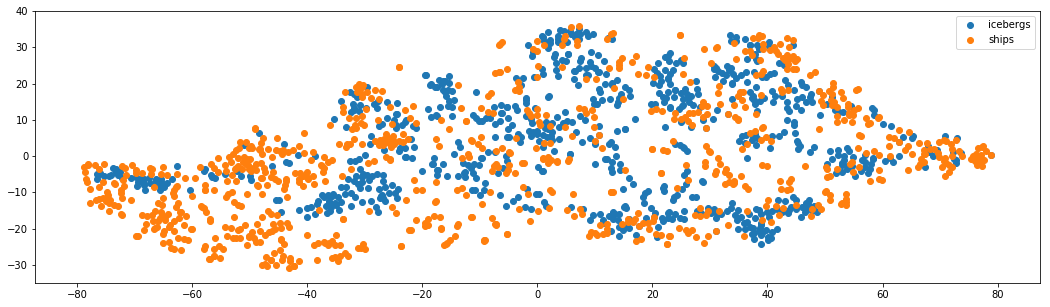

In [18]:
plt.scatter(tsne[measures.is_iceberg == 1, 0], tsne[measures.is_iceberg == 1, 1], label='icebergs')
plt.scatter(tsne[measures.is_iceberg == 0, 0], tsne[measures.is_iceberg == 0, 1], label='ships')
plt.legend();

- ?

### Prototypes

One interesting first point is to look whether there are some prototypes (distinct primitive shapes). This allows to gather insights that will be later useful if there is any unbalanced between icebergs and ships. For example, one could try to cluster similar band 1 together:

In [19]:
from sklearn.cluster import KMeans

In [20]:
n_proto = 4
kmeans = KMeans(n_clusters=n_proto).fit(np.stack(measures.band_1))
kmeans_centers = kmeans.cluster_centers_

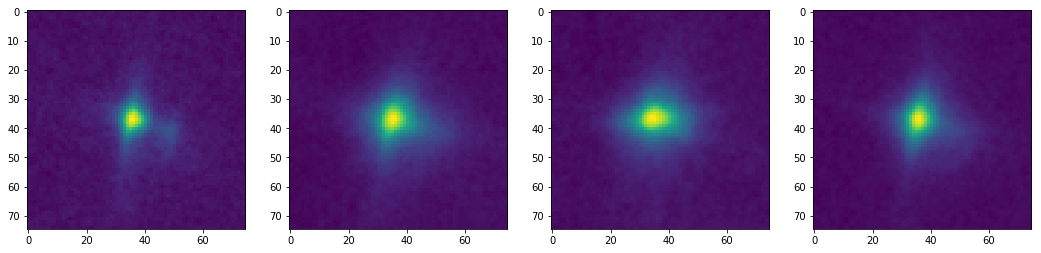

In [21]:
for i, center in enumerate(kmeans_centers):
    plt.subplot(1, 4, i % 4 + 1)
    plt.imshow(center.reshape(75, 75))
    if i % 4 == 3:
        plt.show()

In [22]:
measures.is_iceberg.groupby(kmeans.labels_).apply(pd.value_counts)

0  0    155
   1    114
1  0    224
   1    208
2  0    266
   1     78
3  1    353
   0    206
Name: is_iceberg, dtype: int64

- Scatter effect

---

Looking at a graph based method, ...

## 3 Preprocessing

jusitfiy "no feature" extraction

and why no smoothing

### Train, validation and test splits

later crossval?

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# random state is very important as they same split can be used in other notebooks
train, valtest = train_test_split(range(len(measures)), test_size=0.3, stratify=measures.is_iceberg, random_state=0)
validation, test = train_test_split(valtest, test_size=0.5, stratify=measures.iloc[valtest].is_iceberg, random_state=0)

In [25]:
trainval = np.r_[train, validation]

In [26]:
measures.iloc[train].is_iceberg.value_counts()

0    595
1    527
Name: is_iceberg, dtype: int64

In [27]:
measures.iloc[validation].is_iceberg.value_counts()

0    128
1    113
Name: is_iceberg, dtype: int64

In [28]:
measures.iloc[trainval].is_iceberg.value_counts()

0    723
1    640
Name: is_iceberg, dtype: int64

In [29]:
measures.iloc[test].is_iceberg.value_counts()

0    128
1    113
Name: is_iceberg, dtype: int64

### Cleaning and scaling

only angle, among the trials we saw that replace it by median/mean/fixed number

justify scaling assumption

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
band_scaler = MinMaxScaler()
angle_scaler = MinMaxScaler()

In [32]:
for _, e in measures.iloc[train].iterrows():
    band_scaler.partial_fit(e.band_1.reshape(1, -1))
    band_scaler.partial_fit(e.band_2.reshape(1, -1))
    
angle_scaler.fit(measures.iloc[train].inc_angle.dropna().values.reshape(-1, 1));

In [33]:
# justify
angle_na_replacement = measures.iloc[train].inc_angle.dropna().mean()
angle_na_replacement

39.25610009794319

### Usable data

In [34]:
bands = np.stack([
    band_scaler.transform(np.stack(measures.band_1)),
    band_scaler.transform(np.stack(measures.band_2)),
], axis=1).reshape(-1, 2, 75, 75)

In [35]:
angles = angle_scaler.transform(measures.inc_angle.fillna(angle_na_replacement).values.reshape(-1, 1))

In [36]:
targets = measures.is_iceberg.values.reshape(-1, 1)

## 4 Graphs

### Grid

circular

In [37]:
from gcnn import graph

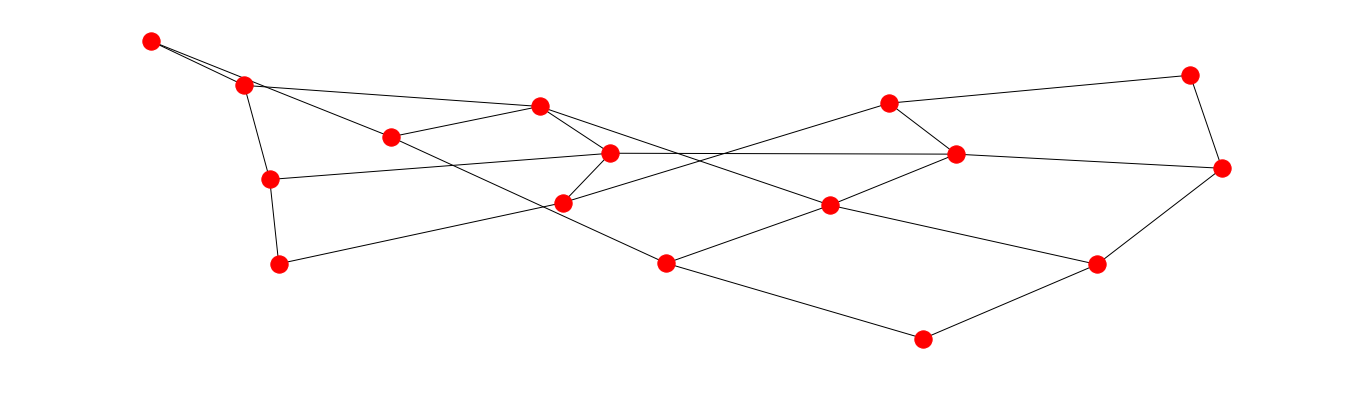

In [38]:
small_grid = nx.grid_graph([4, 4, 1])
nx.draw(small_grid)

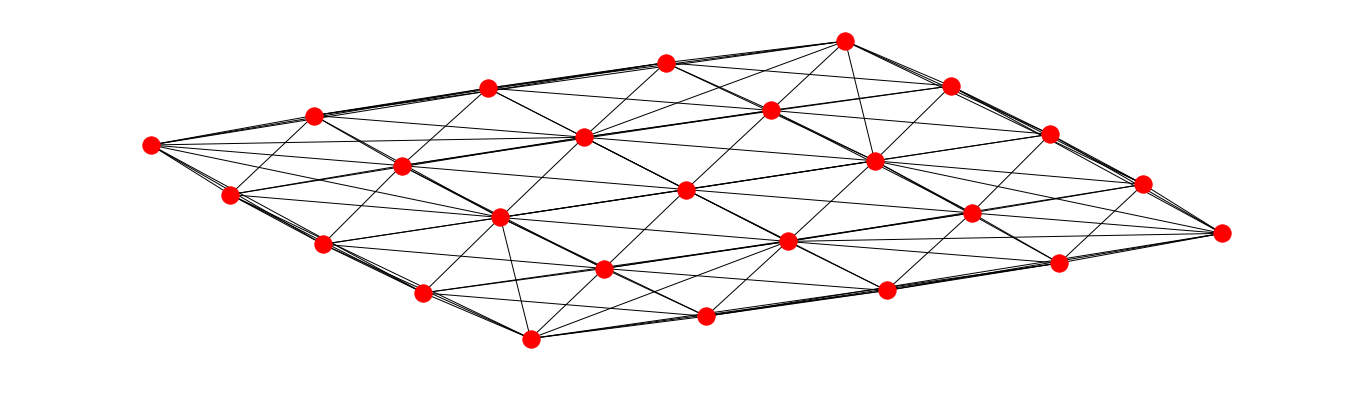

In [39]:
small_knn = graph.knn(graph.grid_coordinates(5), k=8, metric='cityblock')
small_knn = nx.from_numpy_array(small_knn)
nx.draw(small_knn)

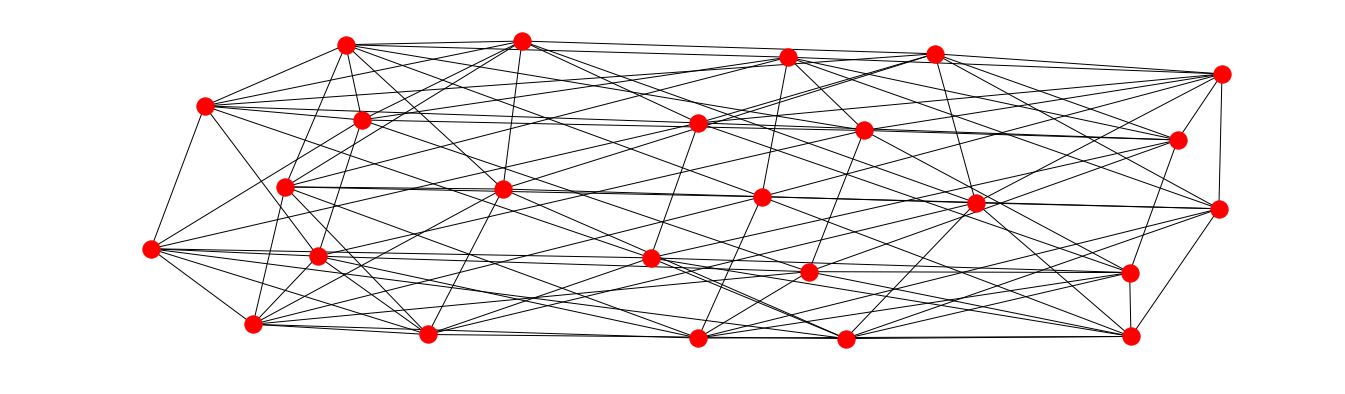

In [40]:
small_wraps = graph.kwraps(5, k=1)
small_wraps = nx.from_numpy_matrix(small_wraps)        
nx.draw(small_wraps)

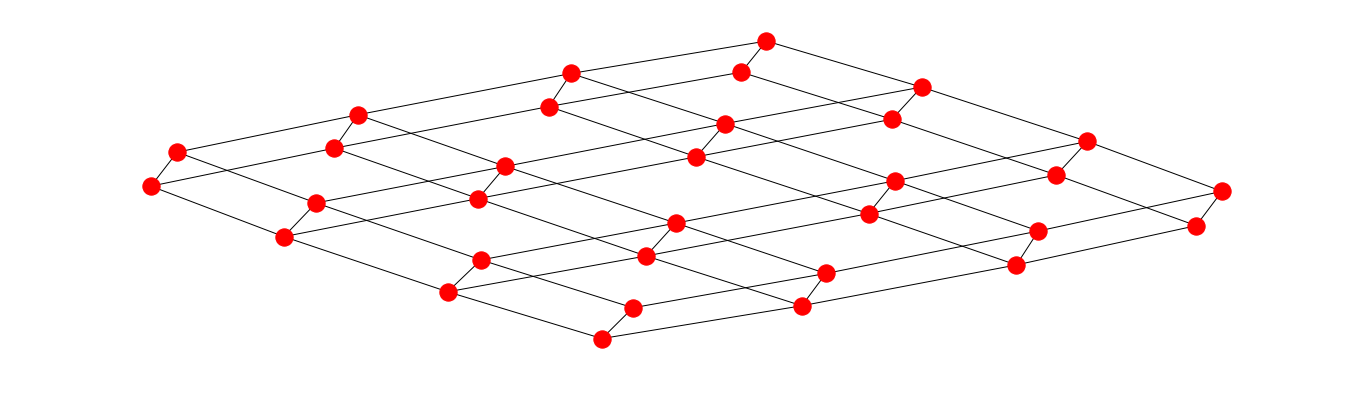

In [41]:
small_grid3d = nx.grid_graph([4, 4, 2])
nx.draw(small_grid3d)

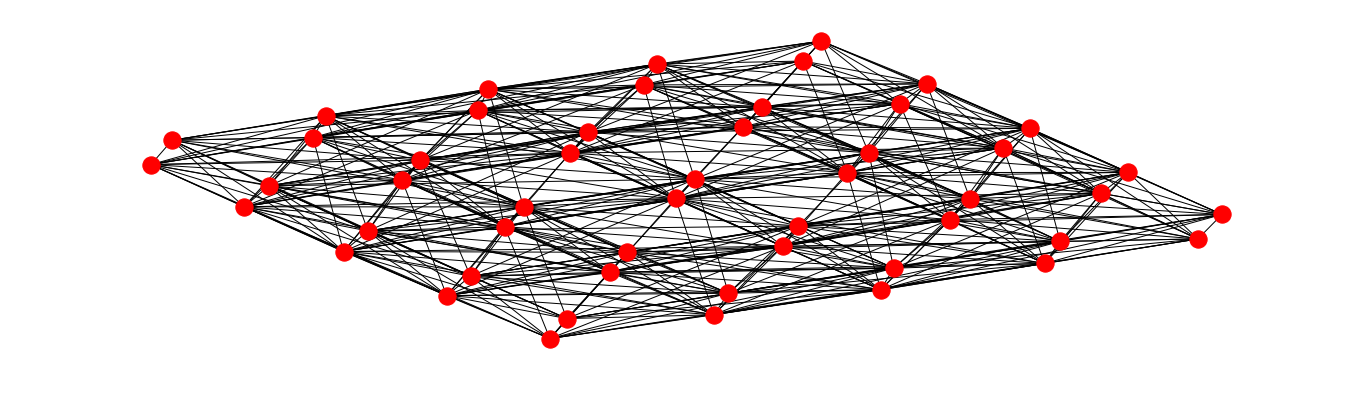

In [42]:
small_knn3d = graph.knn(
    np.r_[
        np.c_[graph.grid_coordinates(5), np.zeros(5 * 5)],
        np.c_[graph.grid_coordinates(5), np.ones(5 * 5)],
    ],
    k=16, 
    metric='cityblock'
)
small_knn3d = nx.from_numpy_array(small_knn3d)
nx.draw(small_knn3d)

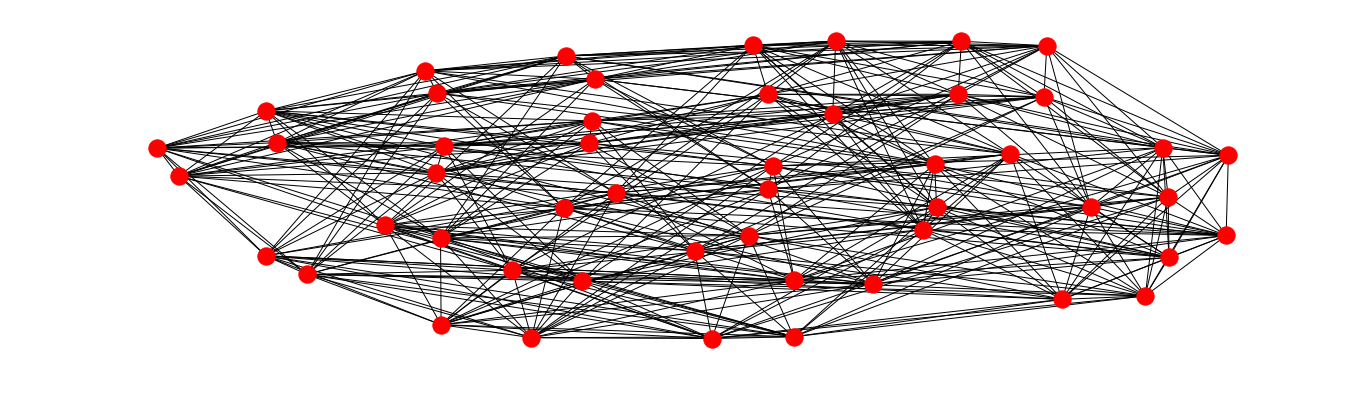

In [43]:
small_wraps3d = graph.kwraps3d(5, k=1, d=2)
nx.draw(small_wraps3d)

analyze those graph in terms of connectivity etc as in homework 2 using networkx power

In [44]:
dict(small_wraps3d.degree).values()

dict_values([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

### Coarsening

demo method sur petit cas ici

graclus implement is courtesy of Michael Defferrard

korn?

algeibraic (spectral cut)

MST


and compare different method in terms of metric we used in homeworks



#### kron reduction

In [45]:
from gcnn.coarsening import kron

In [46]:
small_grid = nx.grid_graph([4, 4, 1])
small_dist = nx.adjacency_matrix(small_grid)

In [47]:
Gs = kron.graph_multiresolution(sp.sparse.csr_matrix(small_dist), levels=3)

ValueError: GRAPH_SPARSIFY: Epsilon out of required range

In [ ]:
for g in Gs:
    g.set_coordinates()
    g.plot()

#### algebraic multigrid

In [ ]:
from gcnn.coarsening import amg

In [ ]:
small_grid = nx.grid_graph([4, 4, 1])
small_dist = nx.adjacency_matrix(small_grid)
graphs, perm = amg.coarsen_amg(small_dist, levels=3, self_connections=False)

In [ ]:
for g in graphs:
    plt.subplot(121)
    plt.spy(g.todense())
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g.todense()))
    plt.show()

#### minimum spanning tree

In [ ]:
from gcnn.coarsening import mst

In [ ]:
small_grid = nx.grid_graph([6, 6, 1])
small_dist = nx.adjacency_matrix(small_grid)
graphs = mst.mst(small_dist.todense(), levels=1)

In [ ]:
for g in graphs:
    plt.subplot(121)
    plt.spy(g)
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g))
    plt.show()

## 5 Models

how to take into account std ?

In [ ]:
scores = pd.DataFrame([], columns=['name', 'accuracy', 'precision', 'recall', 'f1']).set_index('name')
scores

In [ ]:
flat_features = np.c_[bands.reshape(-1, 2 * 75 * 75), angles.reshape(-1, 1)]
flat_features.shape

### Naive methods

knn, logistic

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy = DummyClassifier().fit(flat_features[trainval], targets[trainval].ravel())

In [ ]:
from gcnn.utils import score_classification

In [ ]:
scores.loc['baseline'] = score_classification(targets[test], dummy.predict(flat_features[test]))
scores

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# GridSearchCV in associated notebooks for n
knn = KNeighborsClassifier(n_neighbors=5).fit(flat_features[trainval], targets[trainval].ravel())

In [ ]:
scores.loc['knn'] = score_classification(targets[test], knn.predict(flat_features[test]))
scores

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# GridSearchCV in associated notebooks for C
logistic = LogisticRegression(C=1).fit(flat_features[trainval], targets[trainval].ravel())

In [ ]:
scores.loc['logistic'] = score_classification(targets[test], logistic.predict(flat_features[test]))
scores

### Convolution baseline

say which, why LeNet (paper), gridsearch

integrate angle

In [ ]:
cuda = torch.cuda.is_available()
cuda

In [ ]:
import torch.utils.data as data_utils

In [ ]:
bands_t = torch.from_numpy(bands).float()
angles_t = torch.from_numpy(angles).float()
targets_t = torch.from_numpy(targets).float()

In [ ]:
from gcnn.nets import BaselineCNN
from skorch import NeuralNet

In [ ]:
cnn = NeuralNet(
    BaselineCNN,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss, 
    max_epochs=15,
    batch_size=50,
    lr=0.001,
    use_cuda=cuda
)

In [ ]:
cnn.partial_fit(dict(x=bands_t[train], x2=angles_t[train]), targets_t[train])

In [ ]:
from gcnn.utils import sigmoid

In [ ]:
cnn_predict = sigmoid(cnn.predict_proba(dict(x=bands_t[test], x2=angles_t[test]))).round()

In [ ]:
scores.loc['conv'] = score_classification(targets[test], cnn_predict)
scores

### Graph Convolution

Fourier

In [ ]:
from gcnn.coarsening import graclus
import scipy.sparse
from scipy.sparse import csgraph

In [ ]:
gc_knn_laps = graph.knn(graph.grid_coordinates(75), k=8, metric='cityblock') > 0
# courtesy of Michael Defferrard
gc_knn_laps, gc_knn_perm = graclus.coarsen(sp.sparse.csr.csr_matrix(gc_knn_laps), levels=3, self_connections=False)
gc_knn_laps = [csgraph.laplacian(g, normed=True) for g in gc_knn_laps[:-1]]

In [ ]:
from gcnn.layers import GraphChebyConv

In [ ]:
class Temp(nn.Module):
    
    def __init__(self, conv1_dim=32, conv2_dim=64):
        super().__init__()
        
        l0 = torch.from_numpy(gc_knn_laps[0].todense()).float()
        l2 = torch.from_numpy(gc_knn_laps[2].todense()).float()

        self.gc1 = nn.Sequential(
            # GraphFourierConv(l0.cuda() if cuda else l0, 1, conv1_dim, bias=True),
            GraphChebyConv(l0.cuda() if cuda else l0, 1, conv1_dim, 25, bias=True),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.gc2 = nn.Sequential(
            # GraphFourierConv(l2.cuda() if cuda else l2, conv1_dim, conv2_dim, bias=True),
            GraphChebyConv(l2.cuda() if cuda else l2, conv1_dim, conv2_dim, 25, bias=True),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.fc = nn.Sequential(
            nn.Linear(len(l2) // 4 * conv2_dim, 512),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(512, 1),
        )

    def forward(self, x, x2):
        out = self.gc1(x)
        out = self.gc2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
bands_tg = bands[:, 0, :, :].reshape(-1, 75 * 75)
bands_tg = graclus.perm_data(bands_tg, gc_knn_perm)
bands_tg = torch.from_numpy(bands_tg).float()

In [ ]:
gcnn_knn = NeuralNet(
    Temp,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss, 
    max_epochs=15,
    batch_size=50,
    lr=0.001,
    use_cuda=cuda
)

In [ ]:
gcnn_knn.partial_fit(dict(x=bands_tg[train], x2=angles_t[train]), targets_t[train])

In [ ]:
gcnn_knn_predict = sigmoid(gcnn_knn.predict_proba(dict(x=bands_tg[test], x2=angles_t[test]))).round()

In [ ]:
scores.loc['gcnn_knn'] = score_classification(targets[test], gcnn_knn_predict)
scores

chebyshev

### Graph convolution with amg

In [ ]:
from gcnn.coarsening import amg
import scipy.sparse
from scipy.sparse import csgraph

In [ ]:
gc_knn_laps = graph.knn(graph.grid_coordinates(75), k=8, metric='cityblock') > 0
# courtesy of Michael Defferrard
gc_knn_laps, gc_knn_perm = amg.coarsen_amg(sp.sparse.csr.csr_matrix(gc_knn_laps), levels=3)
gc_knn_laps = [csgraph.laplacian(g, normed=True) for g in gc_knn_laps[:-1]]

In [ ]:
bands_tg = bands[:, 0, :, :].reshape(-1, 75 * 75)
bands_tg = amg.perm_data(bands_tg, gc_knn_perm)
bands_tg = torch.from_numpy(bands_tg).float()

In [ ]:
gcnn_knn = NeuralNet(
    Temp,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss, 
    max_epochs=15,
    batch_size=50,
    lr=0.001,
    use_cuda=cuda
)

In [ ]:
gcnn_knn.partial_fit(dict(x=bands_tg[train], x2=angles_t[train]), targets_t[train])

In [ ]:
gcnn_knn_predict = sigmoid(gcnn_knn.predict_proba(dict(x=bands_tg[test], x2=angles_t[test]))).round()

In [ ]:
scores.loc['gcnn_knn'] = score_classification(targets[test], gcnn_knn_predict)
scores

### Pooling

pattern-based

## 6 Evaluation

### Models

### Stacking

## 7 Conclusion

### Improvements

- sparse operations
- speed

### Acknowledgements

## 8 References

- TORRES, Ramon, SNOEIJ, Paul, GEUDTNER, Dirk, et al. GMES Sentinel-1 mission. Remote Sensing of Environment, 2012, vol. 120, p. 9-24.
- SHUMAN, David I., NARANG, Sunil K., FROSSARD, Pascal, et al. The emerging field of signal processing on graphs: Extending high-dimensional data analysis to networks and other irregular domains. IEEE Signal Processing Magazine, 2013, vol. 30, no 3, p. 83-98.
- BRONSTEIN, Michael M., BRUNA, Joan, LECUN, Yann, et al. Geometric deep learning: going beyond euclidean data. IEEE Signal Processing Magazine, 2017, vol. 34, no 4, p. 18-42.
- DEFFERRARD, Michaël, BRESSON, Xavier, et VANDERGHEYNST, Pierre. Convolutional neural networks on graphs with fast localized spectral filtering. In : Advances in Neural Information Processing Systems. 2016. p. 3844-3852.